# Visualization of Utah COVID-19 Cases for 2020

Inspriation for these visualizations came from [Matt Harrison's](https://www.linkedin.com/in/panela/) daily COVID-19 plots that he began publishing on LinkedIn during the spring of 2020.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Let me see all columns

In [3]:
pd.options.display.max_columns = 999

This is required to eliminate a pandas deprecation warning related to implicit datetime conversions.

In [4]:
pd.plotting.register_matplotlib_converters()

Raw data location on Github

In [5]:
url = ('https://github.com/COVID19Tracking/covid-tracking-data/'
       'raw/master/data/states_daily_4pm_et.csv')

In [6]:
df = pd.read_csv(url, parse_dates=['date', 'dateChecked'])

In [7]:
df[df['state'] == 'UT'].head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
48,2020-04-30,UT,4672.0,103829.0,NaN,NaN,390.0,NaN,NaN,NaN,NaN,1939.0,2b16ca545a1912ee87a5e61644c900f26f69fb79,2020-04-30 20:00:00+00:00,46.0,390.0,108501.0,108501.0,108501.0,49,1.0,7.0,2546.0,177.0,2723.0
104,2020-04-29,UT,4495.0,101283.0,NaN,NaN,383.0,NaN,NaN,NaN,NaN,1790.0,3a41f26bf3b81e58453d42c8b5147b5b5303dc31,2020-04-29 20:00:00+00:00,45.0,383.0,105778.0,105778.0,105778.0,49,0.0,13.0,3187.0,152.0,3339.0
160,2020-04-28,UT,4343.0,98096.0,NaN,NaN,370.0,NaN,NaN,NaN,NaN,1704.0,635cbaea75989c8b5e1add7c80859585284fea5b,2020-04-28 20:00:00+00:00,45.0,370.0,102439.0,102439.0,102439.0,49,4.0,21.0,2134.0,110.0,2244.0
216,2020-04-27,UT,4233.0,95962.0,NaN,NaN,349.0,NaN,NaN,NaN,NaN,1641.0,0c32034bce8f892839893087c6473945d1f85295,2020-04-27 20:00:00+00:00,41.0,349.0,100195.0,100195.0,100195.0,49,0.0,4.0,4383.0,110.0,4493.0
272,2020-04-26,UT,4123.0,91579.0,NaN,NaN,345.0,NaN,NaN,NaN,NaN,1568.0,10d7f1f214d7d7928d0a63a16ec1be3769f2db1e,2020-04-26 20:00:00+00:00,41.0,345.0,95702.0,95702.0,95702.0,49,0.0,16.0,5321.0,175.0,5496.0


In [8]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
formatter = mdates.ConciseDateFormatter(days)

In [9]:
sns.set(context='talk', palette='deep', color_codes=True, style='darkgrid')

## Matt Harrison's Original Plot

With some added `seaborn` styling....

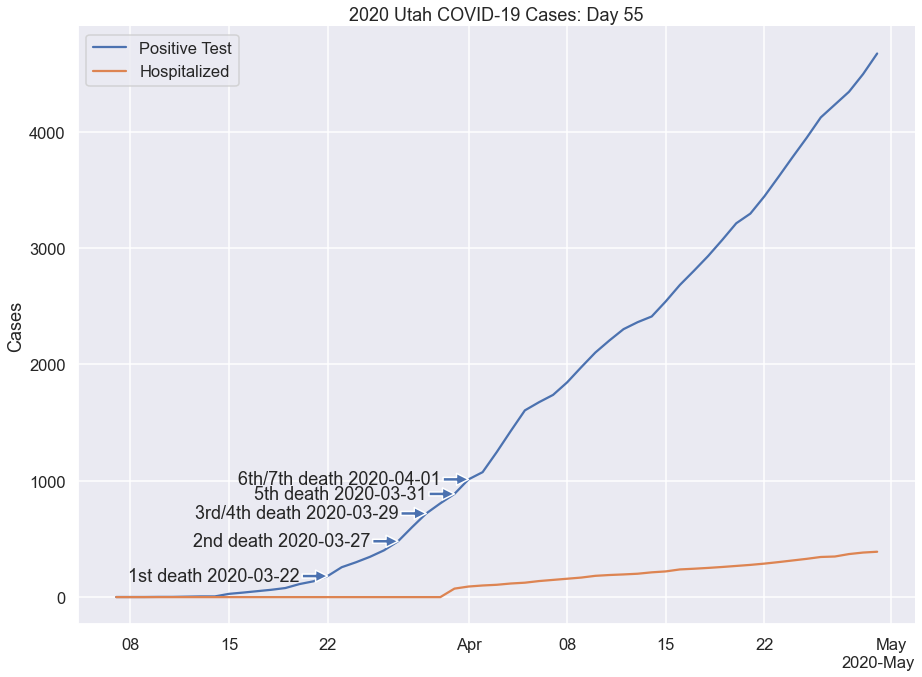

In [10]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death']]
            .fillna(0)
           )
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.plot(data.positive, label='Positive Test')
    ax.plot(data.hospitalized, label='Hospitalized')
    ax.set_ylabel('Cases')
    ax.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')

#     ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    deaths = [
        ('1st', pd.Timestamp('2020-03-22')),
        ('2nd', pd.Timestamp('2020-03-27')),
        ('3rd/4th', pd.Timestamp('2020-03-29')),
        ('5th', pd.Timestamp('2020-03-31')),
        ('6th/7th', pd.Timestamp('2020-04-01'))
    ]
    
    for num, date in deaths:
        val = data.loc[date, 'positive']
        ax.annotate(f'{num} death {date.strftime("%Y-%m-%d")}',
                    xy=(date, val),
                    xytext=(date - pd.DateOffset(days=2), val),
                    arrowprops={},
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    sns.despine()
    ax.legend(loc='upper left')

## Break Out Subplots

How does it look if we break everything out into subplots instead?

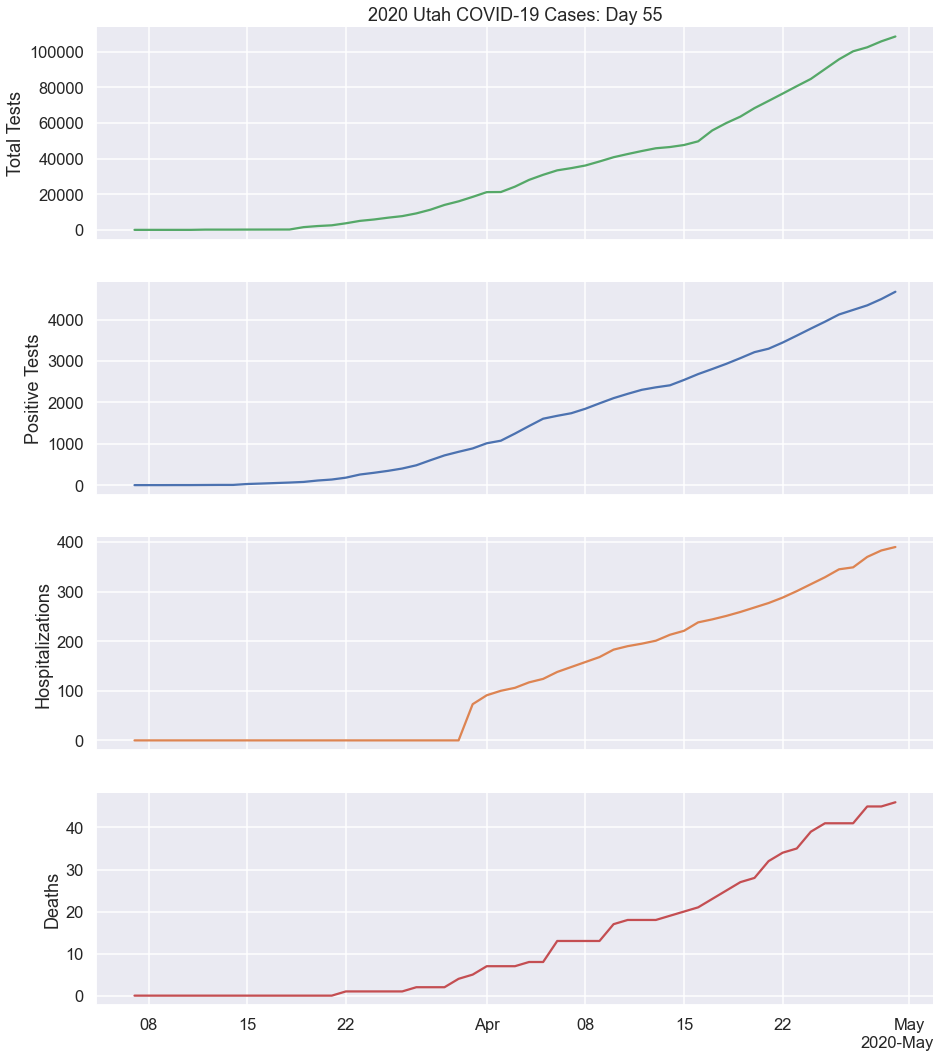

In [11]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
            .fillna(0)
           )
    fig, ax = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
 
    ax[0].plot(data.totalTestResults, color='C2', label='Total Tests')
    ax[0].set_ylabel('Total Tests')
    ax[0].set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    
    ax[1].plot(data.positive, color='C0', label='Positive Test')
    ax[1].set_ylabel('Positive Tests')
    
    ax[2].plot(data.hospitalized, color='C1', label='Hospitalized')
    ax[2].set_ylabel('Hospitalizations')
    
    ax[3].plot(data.death, color='C3', label='Deaths')
    ax[3].set_ylabel('Deaths')

#     ax[0].xaxis.set_major_locator(days)
    ax[0].xaxis.set_major_formatter(formatter)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=0)
    
    sns.despine()

## Multiple Y-Axes on Single Plot

The subplots indicate similar curve shapes. Let's express them on a common plot with multiple y axes. Additionally, let's ignore the missing hospitalization data rather than fill it with zeros.

Inspiration for the multiple axes technique comes from the [Multiple Yaxis Wtih Spines](https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html) example on the matplotlib site.

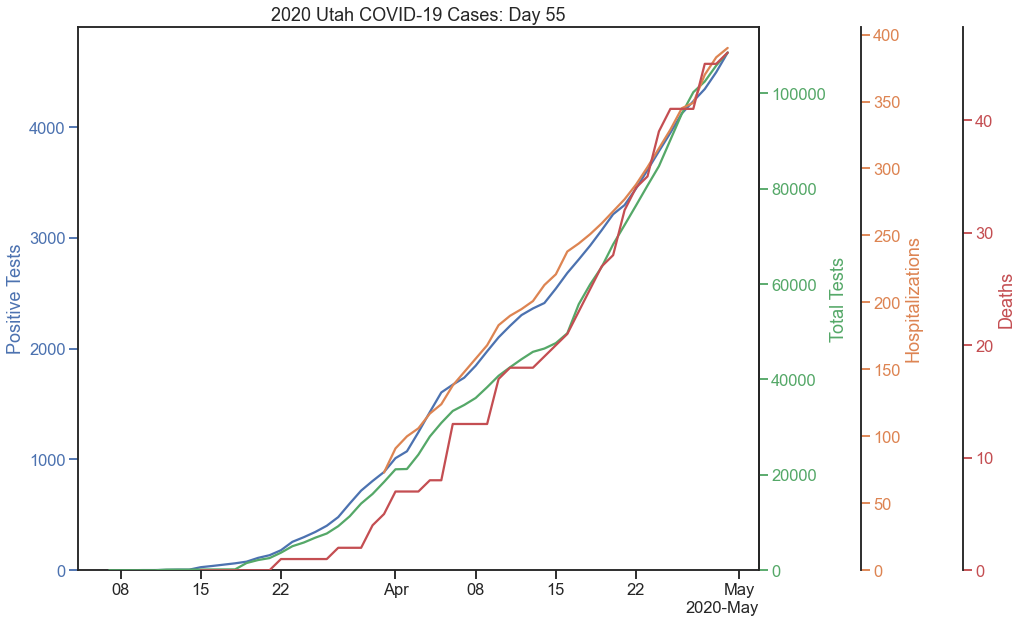

In [12]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
#             .fillna(0)
           )
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.plot(data.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=0.0)
    ax_0.tick_params(axis='y', colors=line_0.get_color(), **tick_kws)

    line_1, = ax_1.plot(data.totalTestResults, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=0.0)
    ax_1.tick_params(axis='y', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.plot(data.hospitalized, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=0.0)
    ax_2.tick_params(axis='y', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.plot(data.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=0.0)
    ax_3.tick_params(axis='y', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()